In [1]:
import yfinance as yf
import pandas as pa
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
stock = input("Pick a stock to check(Ticker):")
strike = float(input("Pick a strike:"))
callorput = input("Are you using a call or put option?")

In [3]:
Ticker = yf.download(stock,
                  period = '1y',
                  progress = False
                  )

/var/folders/64/864crvjd03q3qpksglvs_hmh0000gn/T/ipykernel_2514/1726868661.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Ticker = yf.download(stock,


We need to keep the time frame consistent. Meaning if we want to model the fair option price for a time frame of one year we need to use yahoo finance data for one trading year(about 252 rows)

In [4]:
# log returns
log_returns = np.log(Ticker['Close']/Ticker['Close'].shift(1))
#annuarlized volatility. The .iloc[0] is necessary to convert the volatility to a float value. Before this command, the volatility is a matrix with one row and one column and will cause errors in the GBM formula
volatility = (log_returns.std() * np.sqrt(252)).iloc[0]
# risk free interest rate
r = np.log(1 + 0.0405).item()

Need to use risk free interest rate since we are modeling option prices. Therefore we cannot use drift in Geometric Brownian motion Equation.

In [5]:
# T: simulation duration(in years)
# n: number of time steps(how many days into the future we want to predict)
# r: risk free interest rate
def GBM(r,sigma,n,T,n_sims):
    paths = np.zeros((n_sims,n+1))
    S_0 = Ticker.iloc[-1,0]
    dt = T/n
    paths[:,0] = S_0
    for i in range(n):
        W = np.random.standard_normal(n_sims)
        paths[:,i+1] = paths[:,i] *np.exp((r - 0.5 * sigma**2) * dt + sigma * W * np.sqrt(dt))
    return paths

This example predicts the price of the stock one trading year into the future so T = 1 and n = 252

In [6]:
x = GBM(r,volatility,252,1,10000)
final_prices = x[:,-1]

Text(0.5, 1.0, 'Simulated Price Paths Using Geometric Brownian Motion')

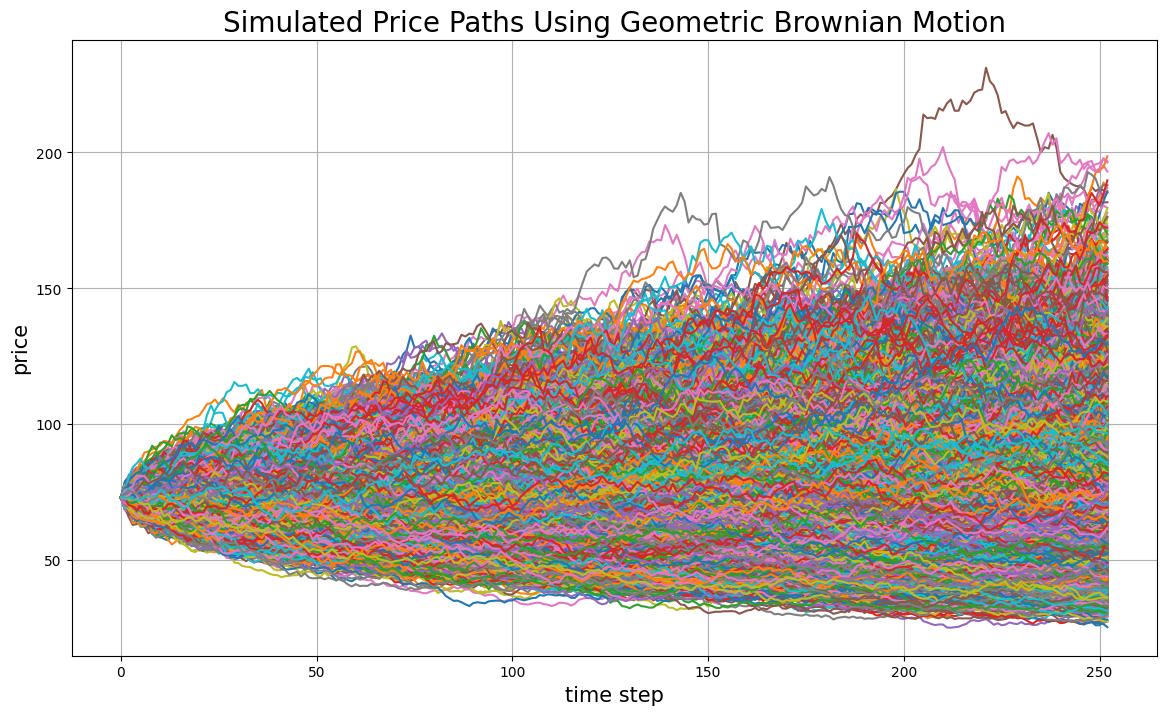

In [16]:
plt.figure(figsize = (14,8))
for row in x:
    plt.plot(row)
plt.grid()
plt.xlabel('time step',fontsize=15)
plt.ylabel('price',fontsize = 15)
plt.title('Simulated Price Paths Using Geometric Brownian Motion',fontsize = 20)

Text(0.5, 1.0, 'Histogram of predicted prices')

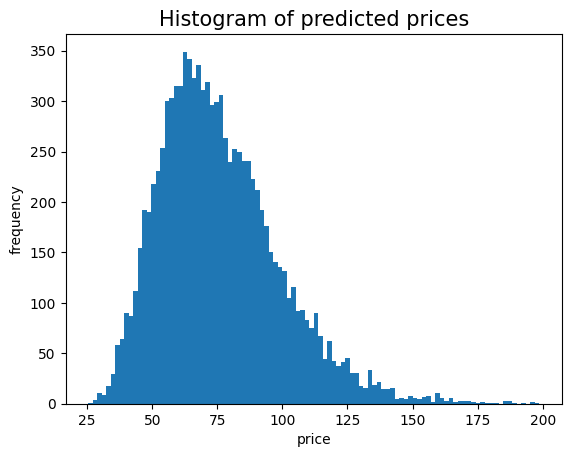

In [8]:
plt.hist(final_prices,100)
plt.xlabel('price',fontsize=10)
plt.ylabel('frequency',fontsize = 10)
plt.title('Histogram of predicted prices',fontsize = 15)

Now we convert this list of predictions of stock price into fair option prices. The code will apply the formula to each path individually, giving us a new distribution

In [9]:
# T has to be the same as for the Brownian Motion equation. In this case me predicted the stock prices one year into the future(T = 1) so we can only predict the fair option price for a year from now. We can choose the value for T. I tried to turn this conversion process into a formula to make it easier. What you have to specify for the formula is the strike price, and the type 'call' or 'put'. you have to put the word in parentheses.
def fair_option_price(strike,T,type):
    discount_factor = np.exp(-r * T)
    if type == 'call':
        payoffs = np.maximum(final_prices-strike,0) * discount_factor
    elif type == 'put':
        payoffs = np.maximum(strike-final_prices,0) * discount_factor
    return payoffs

Text(0.5, 1.0, 'Histogram of predicted fair option price')

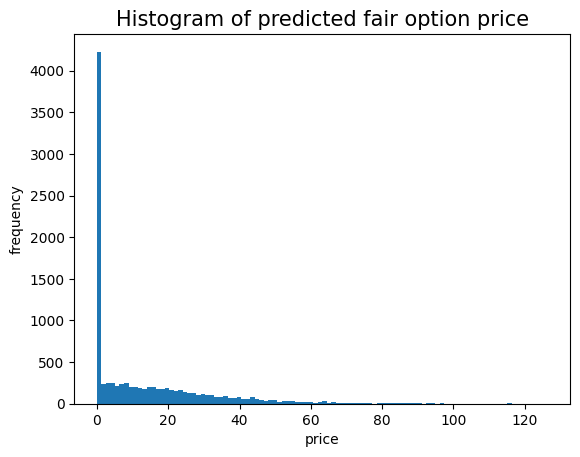

In [10]:
plt.hist(fair_option_price(strike,1,callorput),100)
plt.xlabel('price',fontsize=10)
plt.ylabel('frequency',fontsize = 10)
plt.title('Histogram of predicted fair option price',fontsize = 15)

Black Sholes Equation Prediction

In [11]:
# S = current stock price(S_0)
S_0 = Ticker.iloc[-1,0]
# k = strike price
# T = Time to maturity(same as T from GBM and Fair price formula)
# r = risk free interest rate
# sigma = volatility
# specify put or call option
def black_scholes(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        # Call price = S * N(d1) - K * e^(-rT) * N(d2)
        price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    elif option_type == 'put':
        # Put price = K * e^(-rT) * N(-d2) - S * N(-d1)
        price = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)
    return price

Final Predictions

In [12]:
final_prediction1 = round(fair_option_price(strike,1,callorput).mean(),2)
final_prediction2 = round(black_scholes(S_0,strike,1,r,volatility,callorput),2)
print('Predicted fair option price from Monte Carlo:','$'+str(final_prediction1),', from Black Scholes Equation:','$'+str(final_prediction2))

Predicted fair option price from Monte Carlo: $13.23 , from Black Scholes Equation: $13.27
